<a href="https://colab.research.google.com/github/Vhickyem/Trade-Customs-Analytics/blob/main/Trade_and_Customs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:

# Import depedencies
from google.colab import files
uploaded = files.upload()



Saving custom-import_data.csv to custom-import_data (1).csv


In [44]:
# open data
def wrangle(filepath):
    with open(filepath, "r") as file:
        df = pd.read_csv(file)

    # display first few rows of the dataframe
    #print(df.head())
    # display the shape of the dataframe
    #print(df.shape)
    # display the data types of each column
    #print(df.dtypes)

    # Data wrangling
    # copy dataframe
    data = df.copy().drop(columns=["Unnamed: 0"])
    # Fill receipt number with 'Unknown'
    data["Receipt Number"] = data["Receipt Number"].fillna("Unknown")

    # Flag where Country of Supply matches Origin
    data["self_supply"] = data["Country  of Origin"] == data["Country  of Supply"]

    # Compute rate of self supply by origin
    self_supply_stats = (data.groupby("Country  of Origin")["self_supply"]
                        .mean()
                        .reset_index(name="Self Supply Rate"))
    # Convert to percentage
    self_supply_stats["Self Supply Rate"] = round(self_supply_stats["Self Supply Rate"] * 100, 2)

    # create a sort of lookup table for the country and self supply rate
    rate_dict = dict(
        zip(self_supply_stats["Country  of Origin"], self_supply_stats["Self Supply Rate"])
    )

    # create the imputation function, putting each row in consideration
    def impute_supply(row):
        origin = row["Country  of Origin"]
        supply = row["Country  of Supply"]

        # If the supply is present, keep it
        if pd.notna(supply):
            return supply
        # If supply is missing, check rule
        if rate_dict.get(origin, 0) >= 70:
            return origin # If rate >= 70
        else:
            return "Unknown"


    # Apply the function
    data["Country  of Supply"] = data.apply(impute_supply, axis=1)
    data.drop(columns="self_supply", inplace=True)

    # For Container Nbr and Container Size, if Nbr of Containers is 0,
    # It means, no container was used and we'll fill with Not Apllicable (N/A)
    #if Nbr of Containers >= 1, then we'll fill with unknown
    data["Container Nbr"] = np.where(
        data["Nbr Of Containers"] == '0', "N/A",
        data["Container Nbr"].fillna('Unknown')
    )

    data["Container Size"] = np.where(
        data["Nbr Of Containers"] == '0', "N/A",
        data["Container Size"].fillna('Unknown')
    )

    # Change an Outlier to 1
    data.loc[data["Nbr Of Containers"]=='3248477', 'Nbr Of Containers'] = '1'
    # Change W to 1
    data.loc[data["Nbr Of Containers"]=='W', 'Nbr Of Containers'] = '1'

    # change the years
    # create a mapping dictionary
    year_map = {
        1866: 2021,
        1867: 2022,
        1868: 2023,
        1869: 2024
    }

    # Step 1: Parse Receipt Date
    data["Receipt Date"] = pd.to_datetime(
    data["Receipt Date"], errors="coerce", dayfirst=True
    )

    # replace the years
    data["Receipt Date"] = data["Receipt Date"].apply(
        lambda x:
            x.replace(year=year_map[x.year]) if pd.notna(x) and x.year in year_map else x
    )

    # change data type of Importer
    data["Importer"] = data["Importer"].astype(str)
    # Change for HS Code
    data["HS Code"] = data["HS Code"].astype(str)
    # Change Mass (KG) to integers
    data["Mass(KG)"] = data["Mass(KG)"].str.replace(",", "").astype(int)
    # Change Nbr Of Containers to integers
    data["Nbr Of Containers"] = data["Nbr Of Containers"].astype(int)
    return data

In [45]:
customs_data = wrangle("custom-import_data.csv")
customs_data.head()

/tmp/ipython-input-2232538680.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Custom Office,Reg Number,Importer,HS Code,FOB Value (N),CIF Value (N),Total Tax(N),Receipt Number,Receipt Date,Mass(KG),Country of Origin,Country of Supply,Nbr Of Containers,Container Nbr,Container Size
0,UA PORT,C1195,29143,12900000,1046575,1119220,137105,R599,2021-07-03,126,Germany,Germany,0,N/A,N/A
1,UA PORT,C1195,29143,36700000,216957,232002,68365,R599,2021-07-03,26,Germany,Germany,0,N/A,N/A
2,UA PORT,C1195,29143,39390000,172037,183858,54415,R599,2021-07-03,21,Germany,Germany,0,N/A,N/A
3,UA PORT,C1277,62056,40890000,776007,915286,162868,R621,2021-08-03,71,Belgium,Belgium,0,N/A,N/A
4,UA PORT,C1292,93763,37100000,234651,301040,37415,R614,2021-08-03,45,Turkey,Turkey,0,N/A,N/A


In [46]:
customs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77789 entries, 0 to 77788
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Custom Office       77789 non-null  object        
 1   Reg Number          77789 non-null  object        
 2   Importer            77789 non-null  object        
 3   HS Code             77789 non-null  object        
 4   FOB Value (N)       77789 non-null  int64         
 5   CIF Value (N)       77789 non-null  int64         
 6   Total Tax(N)        77789 non-null  int64         
 7   Receipt Number      77789 non-null  object        
 8   Receipt Date        76493 non-null  datetime64[ns]
 9   Mass(KG)            77789 non-null  int64         
 10  Country  of Origin  77789 non-null  object        
 11  Country  of Supply  77789 non-null  object        
 12  Nbr Of Containers   77789 non-null  int64         
 13  Container Nbr       77789 non-null  object    

In [47]:
# Fix column names: remove extra spaces (including doubles inside)
customs_data.columns = customs_data.columns.str.strip().str.replace(r'\s+', ' ', regex=True)

# Check again
print(customs_data.columns)


Index(['Custom Office', 'Reg Number', 'Importer', 'HS Code', 'FOB Value (N)',
       'CIF Value (N)', 'Total Tax(N)', 'Receipt Number', 'Receipt Date',
       'Mass(KG)', 'Country of Origin', 'Country of Supply',
       'Nbr Of Containers', 'Container Nbr', 'Container Size'],
      dtype='object')


# Descriptive Analysis

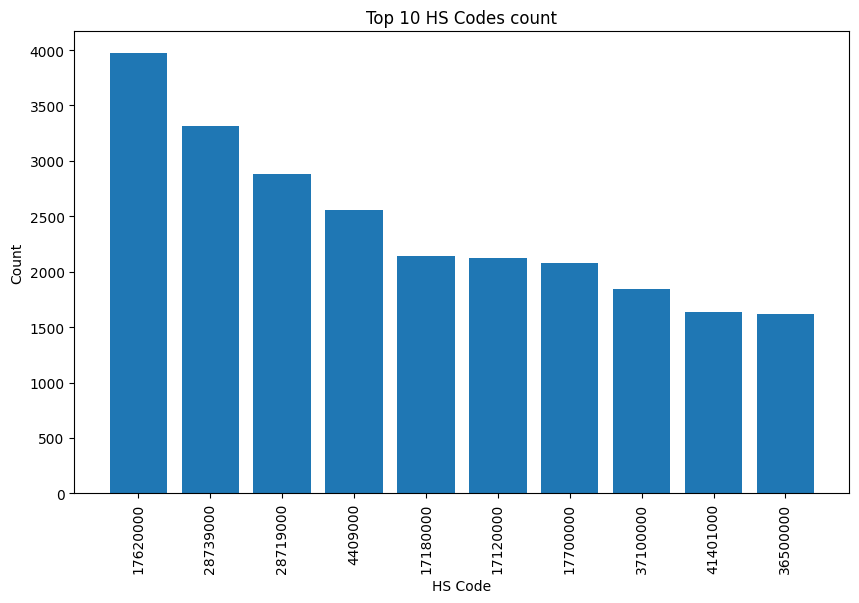

In [48]:
# Totaltop 10 HS CODES
HS_codes= customs_data['HS Code'].value_counts().head(10)
# Plotting
plt.figure(figsize= (10, 6))
plt.bar(HS_codes.index, HS_codes.values)
plt.xlabel('HS Code')
plt.ylabel('Count')
plt.title('Top 10 HS Codes count')
plt.xticks(rotation = 90)
plt.show()


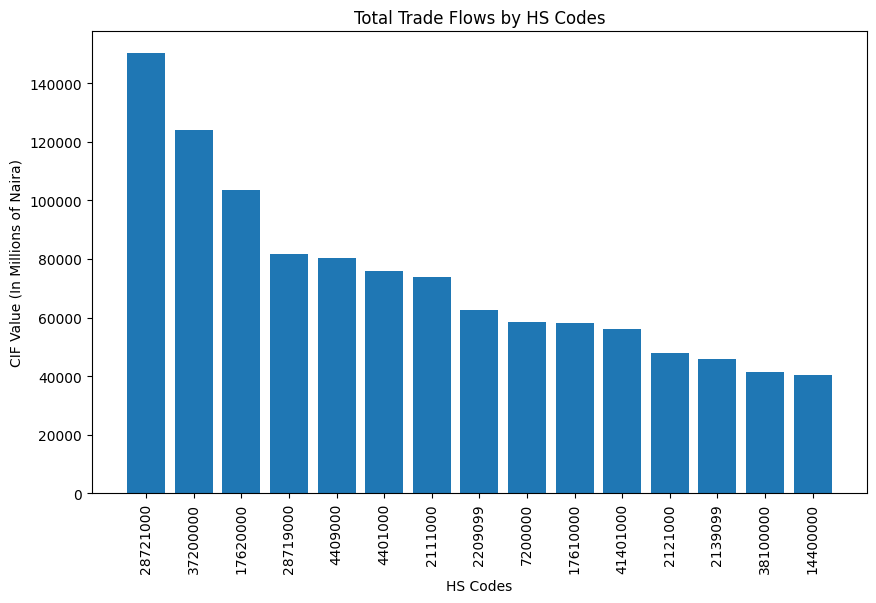

In [49]:
# Total imports by HS Codes
trade_flows= customs_data.groupby('HS Code')['CIF Value (N)'].sum().sort_values(ascending= False).nlargest(15)
trade_flows_mil= (trade_flows/ 1_000_000)

# Plotting
plt.figure(figsize = (10, 6))
plt.bar(trade_flows_mil.index, trade_flows_mil.values)
plt.xlabel('HS Codes')
plt.ylabel('CIF Value (In Millions of Naira)')
plt.title('Total Trade Flows by HS Codes')
plt.xticks(rotation = 90)
plt.show()

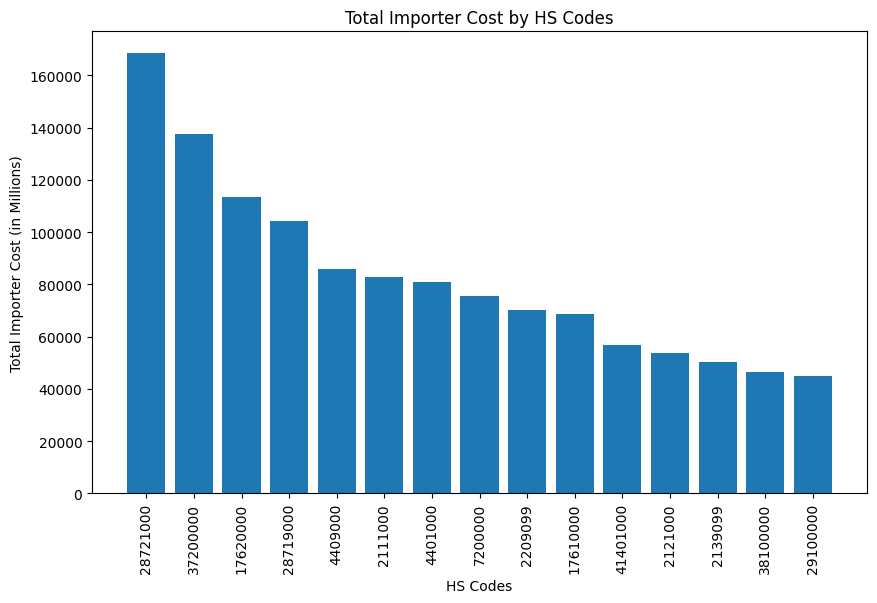

In [50]:
# Total importer's cost by HS Codes
customs_data['importer_cost']= customs_data['CIF Value (N)'] + customs_data['Total Tax(N)']
total_importer_cost= customs_data.groupby('HS Code')['importer_cost'].sum().sort_values(ascending= False).nlargest(15)
# Total importer cost in millions
total_importer_cost_mil= (total_importer_cost/1_000_000)
# Plotting
plt.figure(figsize =(10, 6))
plt.bar(total_importer_cost_mil.index, total_importer_cost_mil.values)
plt.xlabel('HS Codes')
plt.ylabel('Total Importer Cost (in Millions)')
plt.title('Total Importer Cost by HS Codes')
plt.xticks(rotation = 90)
plt.show()


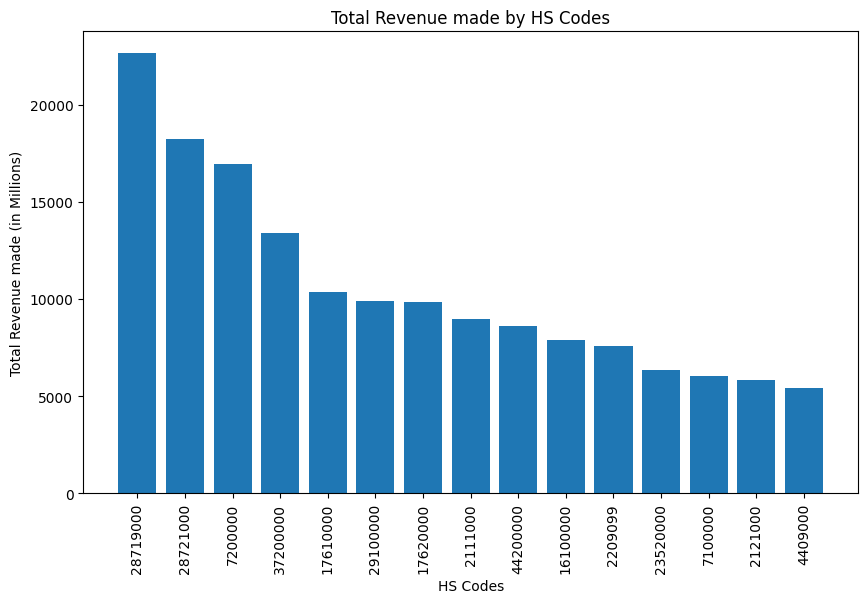

In [51]:
# Total Revenue made by Nigeria
total_revenue= customs_data.groupby('HS Code')['Total Tax(N)'].sum().sort_values(ascending = False).nlargest(15)
# Total revenue in millions
total_revenue_mil = (total_revenue/ 1_000_000)

# Plotting
plt.figure(figsize = (10, 6))
plt.bar(total_revenue_mil.index, total_revenue_mil.values)
plt.xlabel('HS Codes')
plt.ylabel('Total Revenue made (in Millions)')
plt.title('Total Revenue made by HS Codes')
plt.xticks(rotation = 90)
plt.show()



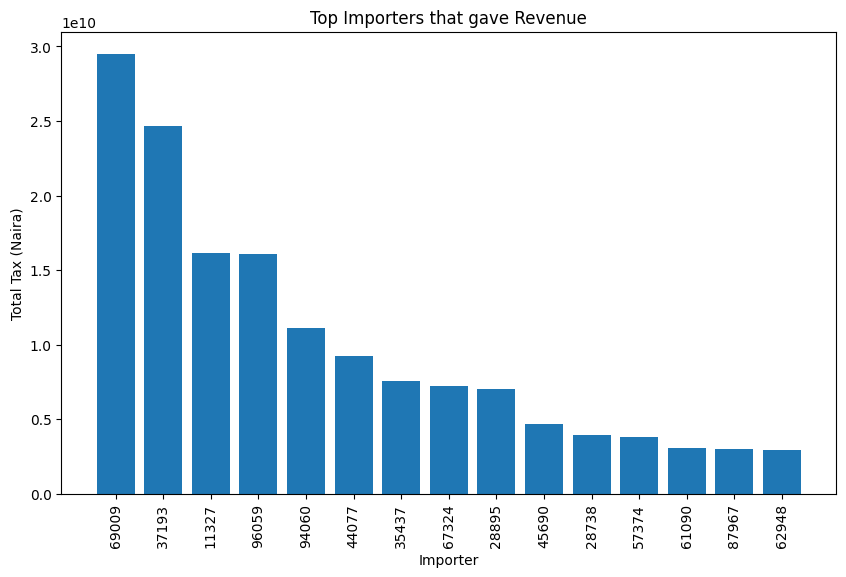

In [52]:
# Key players in trade
importers= customs_data.groupby('Importer')['Total Tax(N)'].sum().sort_values(ascending= False).nlargest(15)

# Plotting
plt.figure(figsize= (10, 6))
plt.bar(importers.index, importers.values)
plt.xlabel('Importer')
plt.ylabel('Total Tax (Naira)')
plt.title('Top Importers that gave Revenue')
plt.xticks(rotation = 90)
plt.show()

In [113]:
'''# Value per KG (efficiency/compliance metric)
customs_data['value_per_kg'] = customs_data['CIF Value (N)'] / customs_data['Mass(KG)']

# Use mean instead of sum for proper per-HS Code metric
value_per_kg = customs_data.groupby('HS Code')['value_per_kg'].mean().sort_values(ascending=False).head(15)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(value_per_kg.index.astype(str), value_per_kg.values)
plt.xlabel('HS Codes')
plt.ylabel('Average Value per KG (Naira)')
plt.title('Top 15 HS Codes by Value per KG')
plt.xticks(rotation=90)
plt.show()
'''

"# Value per KG (efficiency/compliance metric)\ncustoms_data['value_per_kg'] = customs_data['CIF Value (N)'] / customs_data['Mass(KG)']\n\n# Use mean instead of sum for proper per-HS Code metric\nvalue_per_kg = customs_data.groupby('HS Code')['value_per_kg'].mean().sort_values(ascending=False).head(15)\n\n# Plotting\nplt.figure(figsize=(10, 6))\nplt.bar(value_per_kg.index.astype(str), value_per_kg.values)\nplt.xlabel('HS Codes')\nplt.ylabel('Average Value per KG (Naira)')\nplt.title('Top 15 HS Codes by Value per KG')\nplt.xticks(rotation=90)\nplt.show()\n"

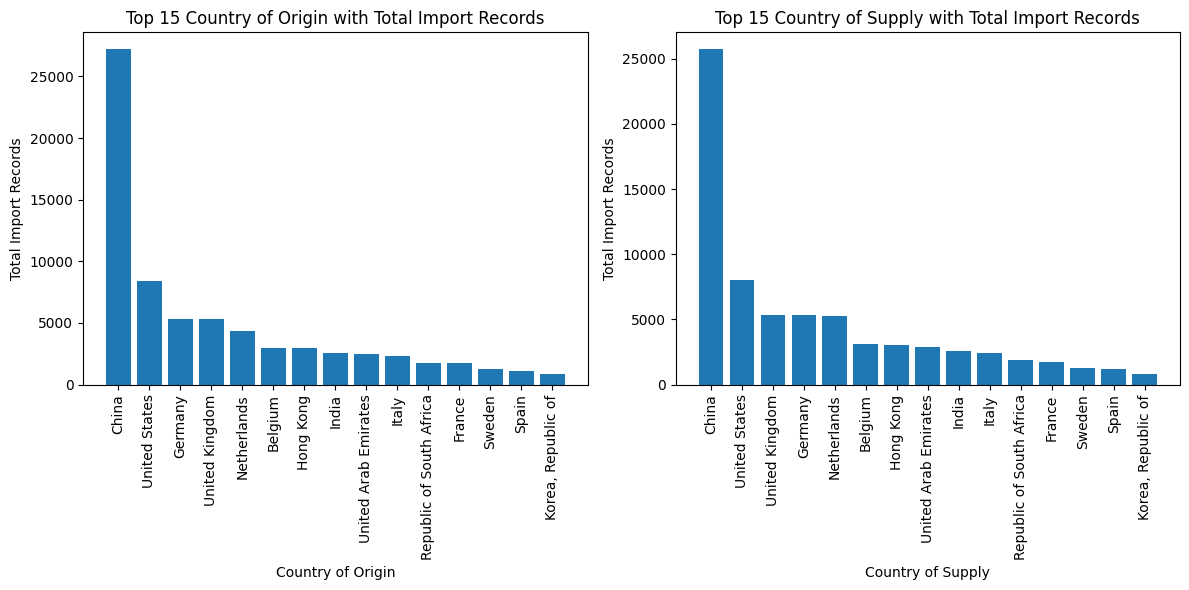

In [54]:
# Country of origin vs country of supply with total import records
country_of_origin= customs_data['Country of Origin'].value_counts().head(15)
country_of_supply= customs_data['Country of Supply'].value_counts().head(15)

# Plotting
plt.figure(figsize = (12, 6)) # Adjusted figure size for two subplots
plt.subplot(1,2, 1)
plt.bar(country_of_origin.index, country_of_origin.values)
plt.xlabel('Country of Origin')
plt.ylabel('Total Import Records')
plt.title('Top 15 Country of Origin with Total Import Records')
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
plt.bar(country_of_supply.index, country_of_supply.values)
plt.xlabel('Country of Supply')
plt.ylabel('Total Import Records')
plt.title('Top 15 Country of Supply with Total Import Records')
plt.xticks(rotation = 90)
plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()

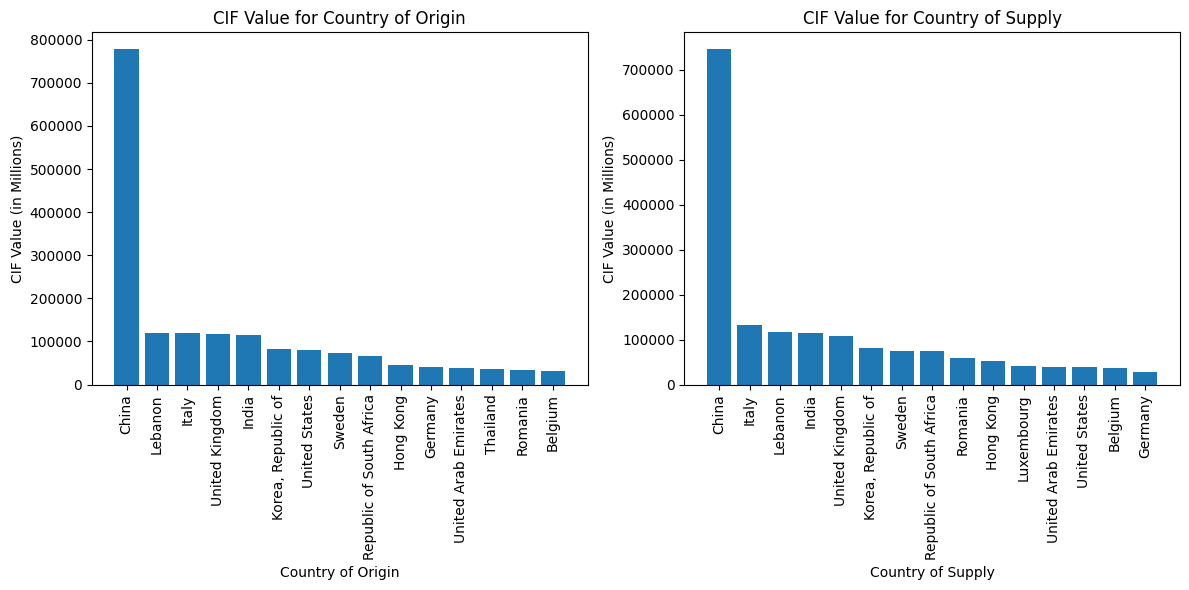

In [55]:
# CIF value for country of origin vs. country of supply
cif_origin = customs_data.groupby('Country of Origin')['CIF Value (N)'].sum().sort_values(ascending = False).nlargest(15)
cif_supply = customs_data.groupby('Country of Supply')['CIF Value (N)'].sum().sort_values(ascending = False).nlargest(15)
# Coverting to Millions
cif_origin= (cif_origin/ 1_000_000)
cif_supply= (cif_supply/1_000_000)

# Plotting
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.bar(cif_origin.index, cif_origin.values)
plt.xlabel('Country of Origin')
plt.ylabel('CIF Value (in Millions)')
plt.title ('CIF Value for Country of Origin')
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)

plt.bar(cif_supply.index, cif_supply.values)
plt.xlabel('Country of Supply')
plt.ylabel('CIF Value (in Millions)')
plt.title('CIF Value for Country of Supply')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

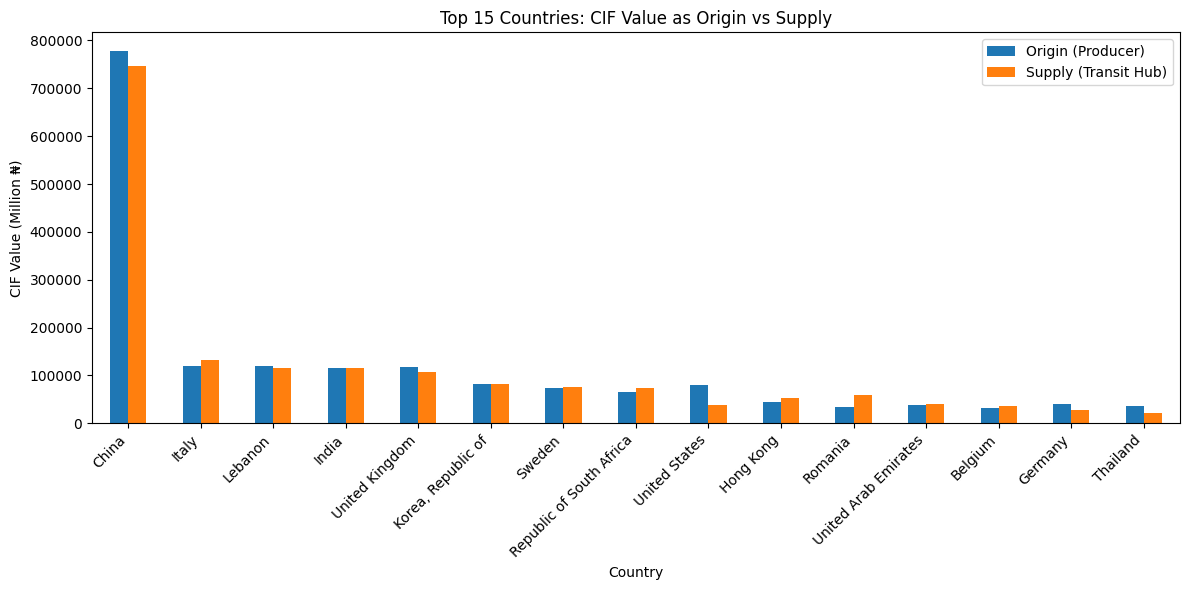

In [82]:
# Aggregate CIF values by Origin and Supply
origin_cif = customs_data.groupby('Country of Origin')['CIF Value (N)'].sum()
supply_cif = customs_data.groupby('Country of Supply')['CIF Value (N)'].sum()

# Merge into one DataFrame
comparison = pd.concat([origin_cif, supply_cif], axis=1)
comparison.columns = ['Origin_CIF', 'Supply_CIF']

# Fill missing values with 0
comparison = comparison.fillna(0)

# Focus on top 15 by total CIF (Origin + Supply)
comparison['Total'] = comparison['Origin_CIF'] + comparison['Supply_CIF']
top_countries = comparison.sort_values('Total', ascending=False).head(15)

# Convert to millions for readability
top_countries = (top_countries / 1_000_000).round(2)

# Plot side-by-side bars
top_countries[['Origin_CIF', 'Supply_CIF']].plot(kind='bar', figsize=(12,6))
plt.title('Top 15 Countries: CIF Value as Origin vs Supply')
plt.ylabel('CIF Value (Million ₦)')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')
plt.legend(['Origin (Producer)', 'Supply (Transit Hub)'])
plt.tight_layout()
plt.show()


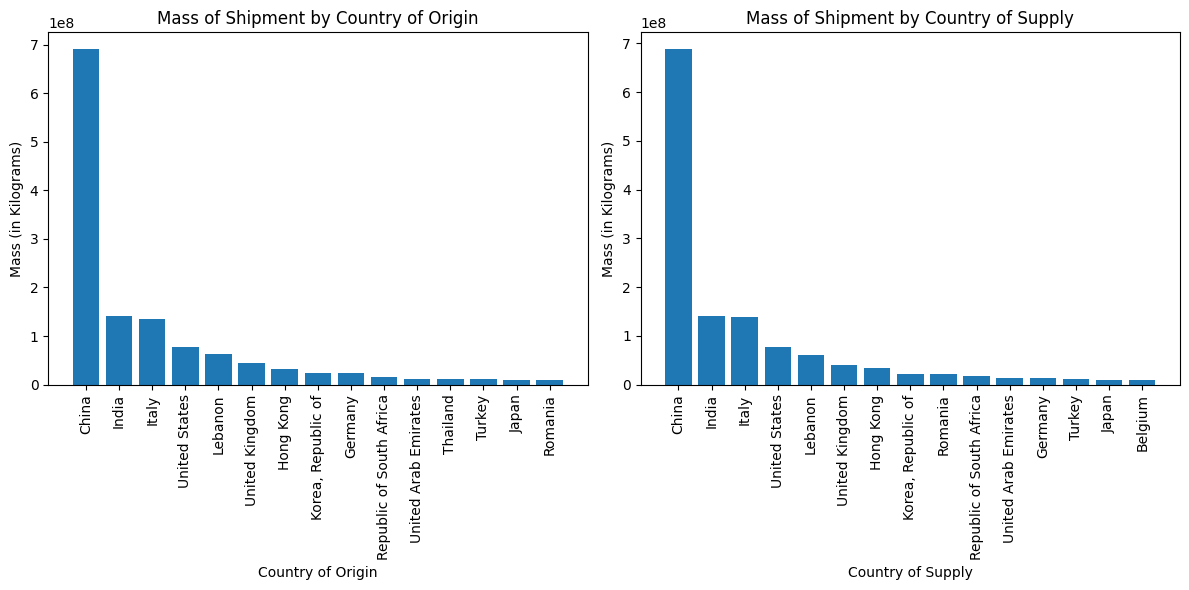

In [56]:
# Amount of shipment based on the mass of shipment
mass_origin = customs_data.groupby('Country of Origin')['Mass(KG)'].sum().sort_values(ascending = False).nlargest(15)
mass_supply = customs_data.groupby('Country of Supply')['Mass(KG)'].sum().sort_values(ascending = False).nlargest(15)

# Plotting
plt.figure(figsize= (12,6))
plt.subplot(1, 2, 1)
plt.bar(mass_origin.index, mass_origin.values)
plt.xlabel('Country of Origin')
plt.ylabel('Mass (in Kilograms)')
plt.title('Mass of Shipment by Country of Origin')
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)
plt.bar(mass_supply.index, mass_supply.values)
plt.xlabel('Country of Supply')
plt.ylabel('Mass (in Kilograms)')
plt.title('Mass of Shipment by Country of Supply')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

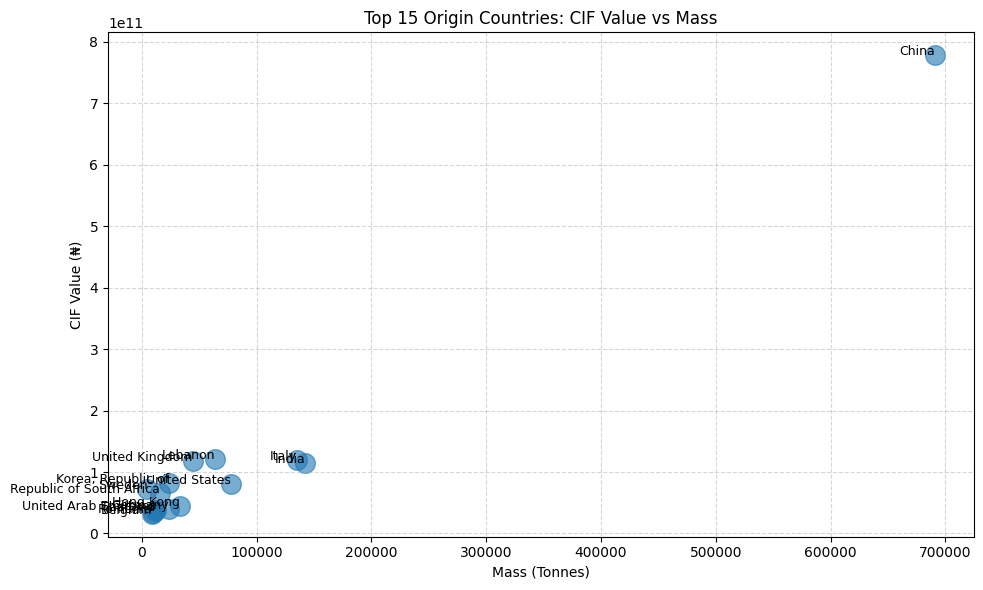

In [80]:

# Aggregate CIF and Mass by Origin
origin_cif = customs_data.groupby('Country of Origin')['CIF Value (N)'].sum()
origin_mass = customs_data.groupby('Country of Origin')['Mass(KG)'].sum()

# Merge both into one DataFrame
origin_summary = pd.concat([origin_cif, origin_mass], axis=1).fillna(0)
origin_summary.columns = ['CIF_Value', 'Mass(KG)']

# Convert Mass to tonnes for readability
origin_summary['Mass_Tonnes'] = origin_summary['Mass(KG)'] / 1000

# Focus on top 15 countries by CIF value
top_origin = origin_summary.sort_values('CIF_Value', ascending=False).head(15)

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(top_origin['Mass_Tonnes'], top_origin['CIF_Value'], s=200, alpha=0.6)

# Add country labels
for country, row in top_origin.iterrows():
    plt.text(row['Mass_Tonnes'], row['CIF_Value'], country, fontsize=9, ha='right')

plt.xlabel('Mass (Tonnes)')
plt.ylabel('CIF Value (₦)')
plt.title('Top 15 Origin Countries: CIF Value vs Mass')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## UNDERSTANDING DIRECT EXPORTERS AND TRANSIT HUBS

In [68]:
direct_exporters = customs_data[customs_data['Country of Origin'] == customs_data['Country of Supply']]
transit_hubs = customs_data[customs_data['Country of Origin'] != customs_data['Country of Supply']]

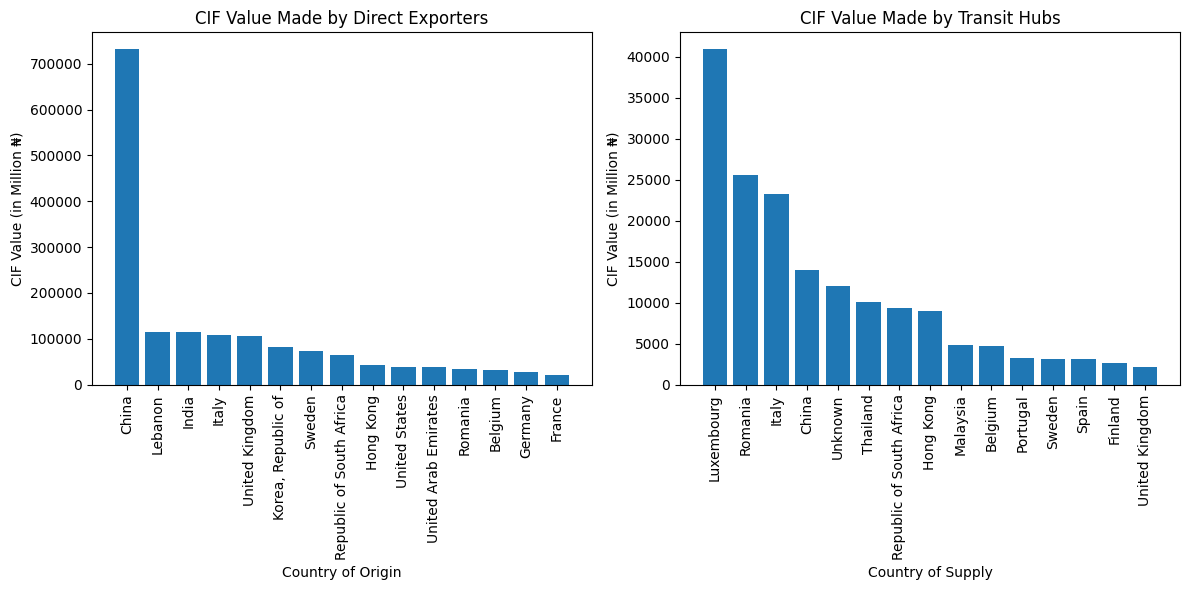

In [75]:
# Comparing CIF value made by direct exporters vs transit hubs
cif_direct_exporters = direct_exporters.groupby('Country of Origin')['CIF Value (N)'].sum().sort_values(ascending = False).nlargest(15)
cif_transit_hubs = transit_hubs.groupby('Country of Supply')['CIF Value (N)'].sum().sort_values(ascending = False).nlargest(15)

# Converting to Millions
cif_direct_exporters = (cif_direct_exporters / 1_000_000).round(2)
cif_transit_hubs = (cif_transit_hubs / 1_000_000).round(2)

# Plotting to compare
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.bar(cif_direct_exporters.index, cif_direct_exporters.values)
plt.xlabel('Country of Origin')
plt.ylabel('CIF Value (in Million ₦)')
plt.title('CIF Value Made by Direct Exporters')
plt.xticks(rotation = 90)

# For transit hubs
plt.subplot(1, 2, 2)
plt.bar(cif_transit_hubs.index, cif_transit_hubs.values)
plt.xlabel('Country of Supply')
plt.ylabel('CIF Value (in Million ₦)')
plt.title('CIF Value Made by Transit Hubs')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

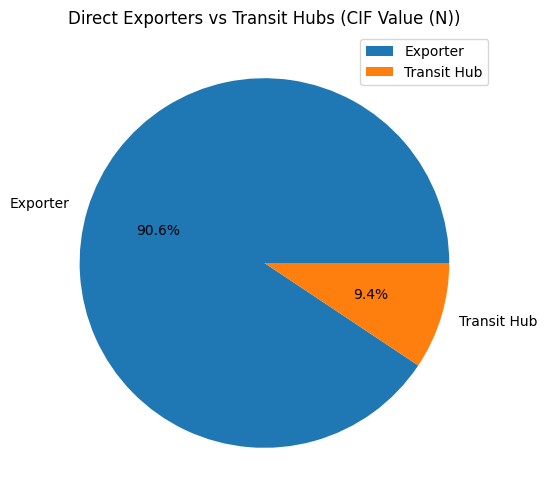

In [91]:
# Pie chart to show overall percentage of direct exporters vs transit hubs
pie_exporters= direct_exporters['CIF Value (N)'].sum()
pie_transit_hubs= transit_hubs['CIF Value (N)'].sum()

# Plotting graph
plt.figure(figsize = (10, 6))
plt.pie(
    [pie_exporters, pie_transit_hubs],
    labels= ['Exporter', 'Transit Hub'],
    autopct='%1.1f%%'
)
plt.title('Direct Exporters vs Transit Hubs (CIF Value (N))')
plt.legend()
plt.show()


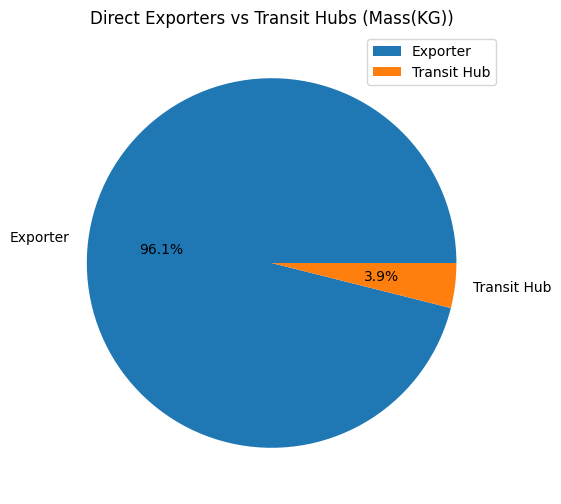

In [92]:
# Pie chart to show overall percentage of direct exporters vs transit hubs
mass_exporters= direct_exporters['Mass(KG)'].sum()
mass_transit_hubs= transit_hubs['Mass(KG)'].sum()

# Plotting graph
plt.figure(figsize = (10, 6))
plt.pie(
    [mass_exporters, mass_transit_hubs],
    labels= ['Exporter', 'Transit Hub'],
    autopct='%1.1f%%'
)
plt.title('Direct Exporters vs Transit Hubs (Mass(KG))')
plt.legend()
plt.show()


## Trend over time

/tmp/ipython-input-3620594311.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_cif = customs_data.groupby('Month')['CIF Value (N)'].sum()
/tmp/ipython-input-3620594311.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_tax = customs_data.groupby('Month')['Total Tax(N)'].sum()
/tmp/ipython-input-3620594311.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_mass = customs_data.groupby('Month

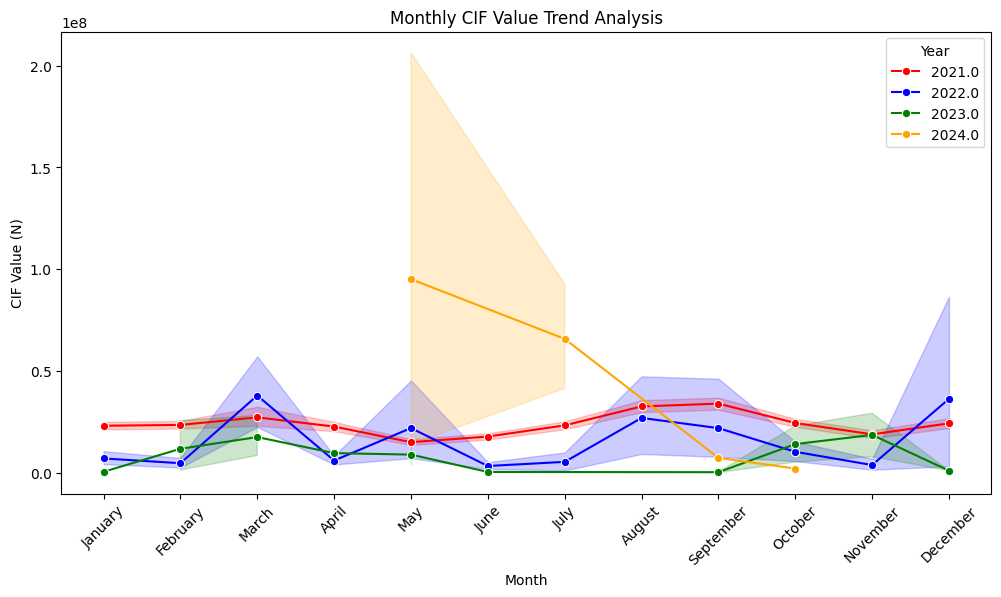

In [112]:
# Grouping datetime by month
customs_data['Date']= pd.to_datetime(customs_data['Receipt Date'])
customs_data['Month']= customs_data['Date'].dt.month

customs_data['Year']= customs_data['Date'].dt.year.astype('Int64')


# Getting Month Names
month_names= {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}
customs_data['Month']= customs_data['Month'].map(month_names)

# Months names being in month order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
customs_data['Month'] = pd.Categorical(customs_data['Month'], categories = months_order, ordered= True)

# Monthly CIF Value
monthly_cif = customs_data.groupby('Month')['CIF Value (N)'].sum()

# Monthly Tax
monthly_tax = customs_data.groupby('Month')['Total Tax(N)'].sum()

# Monthly Mass(KG)
monthly_mass = customs_data.groupby('Month')['Mass(KG)'].sum()

custom_palette = {
    2021: "red",
    2022: "blue",
    2023: "green",
    2024: "orange"
}
# Plotting the graphs in subplot using line graph
# For monthly CIF
plt.figure(figsize = (12, 6))
sns.lineplot(
    data=customs_data,
    x='Month',
    y='CIF Value (N)',
    hue='Year',
    marker='o',
    palette=custom_palette
)
plt.title('Monthly CIF Value Trend Analysis')
plt.xlabel('Month')
plt.ylabel('CIF Value (N)')
plt.xticks(rotation= 45)
plt.legend(title= 'Year')
plt.show()




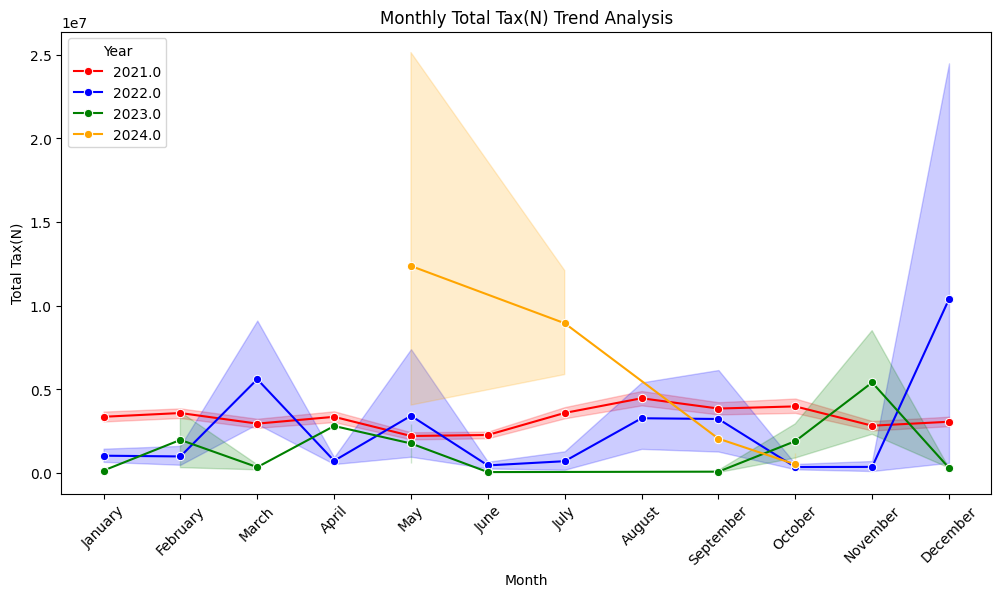

In [110]:
# For Monthly Tax
plt.figure(figsize= (12, 6))
sns.lineplot(
    data=customs_data,
    x='Month',
    y='Total Tax(N)',
    hue='Year',
    marker='o',
    palette=custom_palette
)
plt.title('Monthly Total Tax(N) Trend Analysis')
plt.xlabel('Month')
plt.ylabel('Total Tax(N)')
plt.xticks(rotation= 45)
plt.legend(title= 'Year')
plt.show()

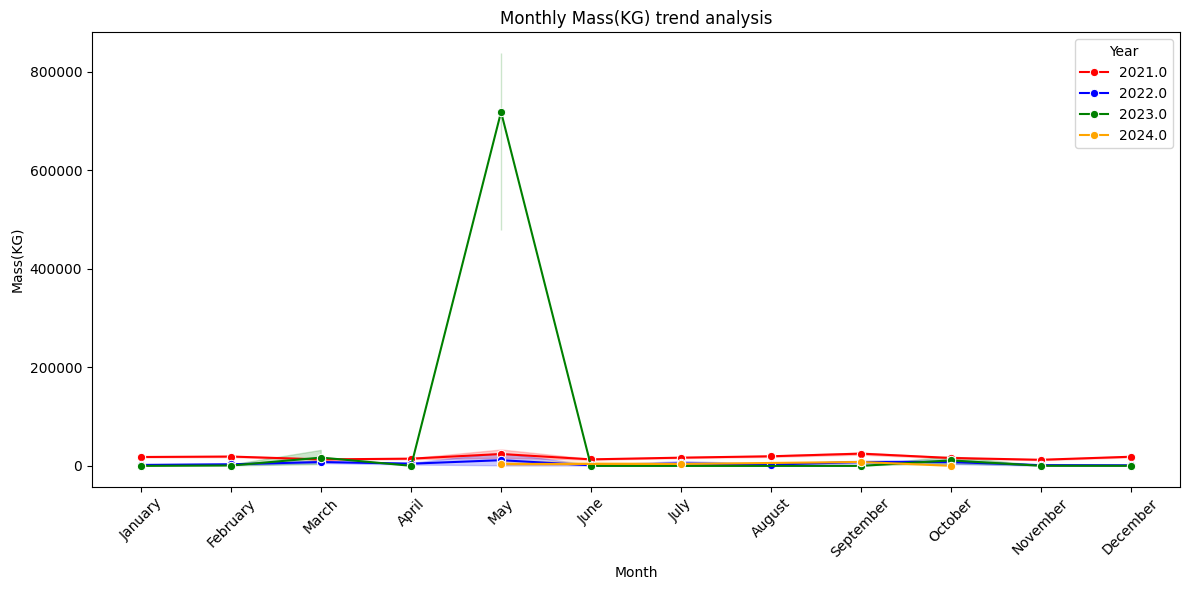

In [108]:
# For Monthtly Mass(KG)
plt.figure(figsize= (12,6))
sns.lineplot(
    data= customs_data,
    x = 'Month',
    y = 'Mass(KG)',
    hue= 'Year',
    marker = 'o',
    palette = custom_palette

)
plt.title('Monthly Mass(KG) Trend analysis')
plt.xlabel('Month')
plt.ylabel('Mass(KG)')
plt.xticks(rotation= 45)
plt.legend(title= 'Year')
plt.tight_layout()
plt.show()


## Outlier Detection

## Logistics and Shipment KPIs

- Total Number of Shipments
- Average Number of Containers per Importer
-  Most Common Container Size
- Total Weight of Imports by Country of Origin

In [57]:
# Total number of shipments
total_shipments= len(customs_data)
print(f'Total Number of Shipments: {total_shipments}')

Total Number of Shipments: 77789


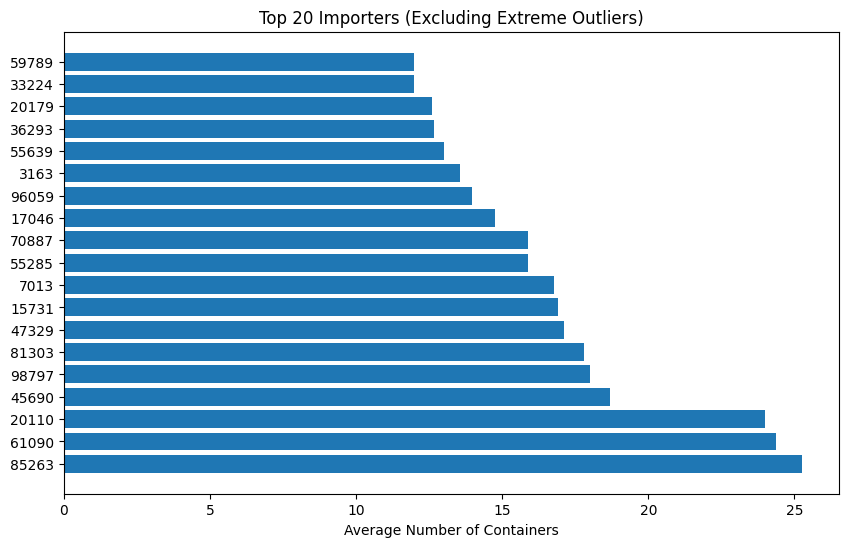

In [64]:
# Average number of containers per importer
avg_container= customs_data.groupby('Importer')['Nbr Of Containers'].mean().nlargest(20)
top_importers = avg_container.nlargest(20)

filtered = avg_container[avg_container < avg_container.quantile(0.95)]  # drop top 5% extreme
top_importers = filtered.nlargest(20)

# Plotting graph
plt.figure(figsize=(10,6))
plt.barh(top_importers.index, top_importers.values)
plt.xlabel('Average Number of Containers')
plt.title('Top 20 Importers (Excluding Extreme Outliers)')
plt.show()



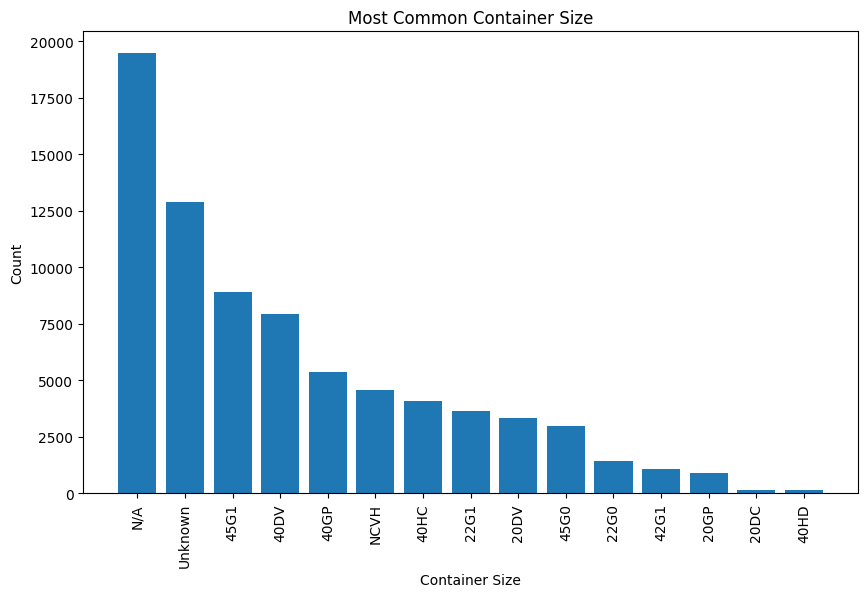

In [66]:
# Most Common Container Size
container_size= customs_data['Container Size'].value_counts().head(15)

# Plotting
plt.figure(figsize= (10, 6))
plt.bar(container_size.index, container_size.values)
plt.xlabel('Container Size')
plt.ylabel('Count')
plt.title('Most Common Container Size')
plt.xticks(rotation= 90)
plt.show()

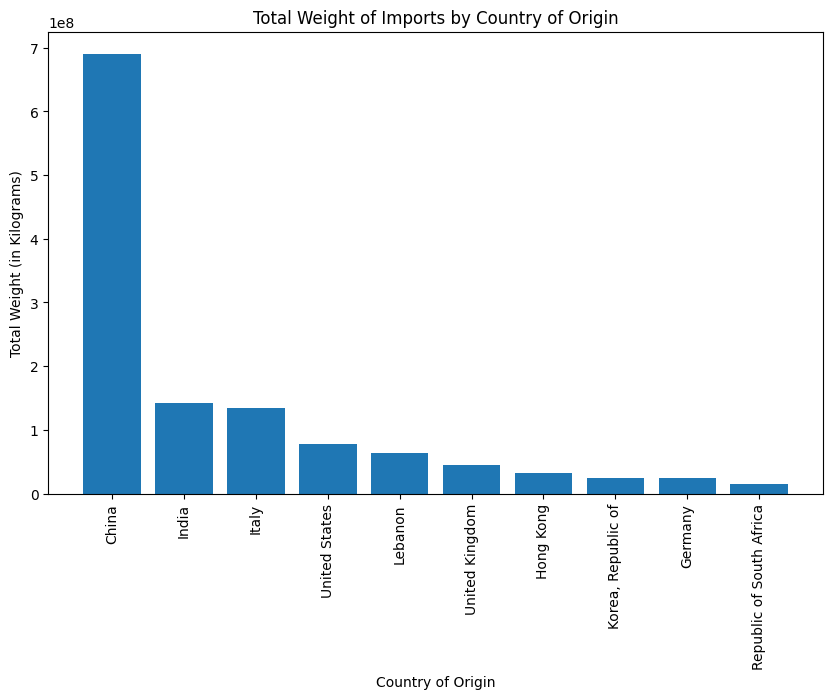

In [67]:
# Total Weight of Imports by Country of Origin
total_weight= customs_data.groupby('Country of Origin')['Mass(KG)'].sum().sort_values().nlargest(10)

# Plotting
plt.figure(figsize= (10, 6))
plt.bar(total_weight.index, total_weight.values)
plt.xlabel('Country of Origin')
plt.ylabel('Total Weight (in Kilograms)')
plt.title('Total Weight of Imports by Country of Origin')
plt.xticks(rotation = 90)
plt.show()